In [ ]:
# Aligns a score volume with an annotation volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from collections import defaultdict

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

atlasAlignOptLogs_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs_atlas_affine')
atlasAlignParams_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams_atlas_affine')

In [4]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [5]:
stack = 'MD603'

In [35]:
# atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack': stack}))
atlasProjected_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_localAdjustedVolume.bp' % {'stack': stack}))

In [36]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(atlasProjected_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [38]:
def parallel_where(name, num_samples=None):
    
    w = np.where(atlasProjected_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlasProjected_nzs = Parallel(n_jobs=4)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
atlasProjected_nzs = dict(zip(available_labels_sided, atlasProjected_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 8.679021 seconds


In [39]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [40]:
def surr_points(arr):
    poly = Polygon(arr)
    p1 = points_in_polygon(list(poly.buffer(10, resolution=2).exterior.coords))
    p2 = points_in_polygon(list(poly.exterior.coords))
    surr_pts = pts_arr_setdiff(p1, p2)
    return surr_pts

def points_in_polygon(polygon):
    pts = np.array(polygon, np.int)
    xmin, ymin = pts.min(axis=0)
    xmax, ymax = pts.max(axis=0)
#     nz_ys, nz_xs = np.where(grid_points_in_poly((ymax-ymin+1, xmax-xmin+1), pts-[xmin, ymin]))
    nz_ys, nz_xs = np.where(grid_points_in_poly((ymax-ymin+1, xmax-xmin+1), pts[:, ::-1]-[ymin, xmin]))
    nz2 = np.c_[nz_xs + xmin, nz_ys + ymin]
    return nz2

def pts_arr_setdiff(nz1, nz2):
    # http://stackoverflow.com/a/11903368
    a1_rows = nz1.view([('', nz1.dtype)] * nz1.shape[1])
    a2_rows = nz2.view([('', nz2.dtype)] * nz2.shape[1])
    surr_nzs = np.setdiff1d(a1_rows, a2_rows).view(nz1.dtype).reshape(-1, nz1.shape[1])
    return surr_nzs

from collections import defaultdict

# q = True

surr_volume = defaultdict(list)
for z in range(atlasProjected_volume.shape[2]):
    cnts = find_contour_points(atlasProjected_volume[..., z])
    for l, cnt in cnts.iteritems():
        try:
            surr_p = surr_points(cnt[0])
            
#             if q:
#                 test_section = np.zeros(atlasProjected_volume.shape[:2], np.uint8)

#                 nzs = surr_nzs['7N_L']
#                 test_section[nzs[:,1], nzs[:,0]] = 1

#                 nzs2 = atlasProjected_nzs['7N_L']
#                 test_section[nzs2[:,1], nzs2[:,0]] = 2

#                 plt.imshow(test_section);
#                 plt.show();
                
#                 q = False
                
            surr_volume[labels_sided[l-1]].append(np.c_[surr_p, z*np.ones(len(surr_p),)])
        except:
            continue
surr_volume.default_factory = None

del surr_p, cnts

surr_nzs_full = {l: np.concatenate(arr_list).astype(np.int16) for l, arr_list in surr_volume.iteritems()}

del surr_volume

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
ERROR:shapely.geos:IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
ERROR:shapely.geos:Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
ERROR:shapely.geos:IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
ERROR:shapely.geos:Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
ERROR:shapely.geos:IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
ERROR:shapely.geos:Shell is not a LinearRing


In [41]:
surr_nzs = {}

num_samples = 1e5

for name, nzs in surr_nzs_full.iteritems():
    n = len(nzs)
    sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
    surr_nzs[name] = nzs[sample_indices]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


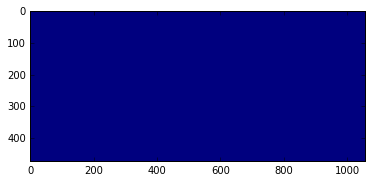

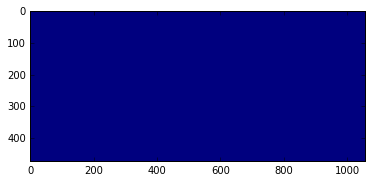

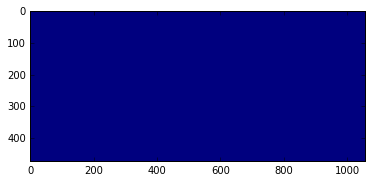

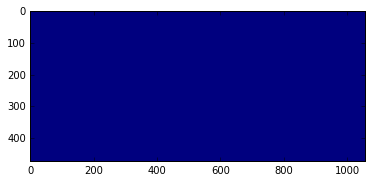

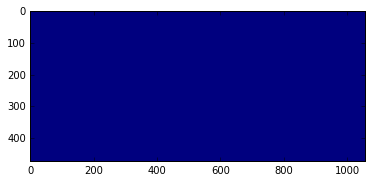

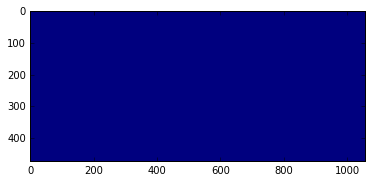

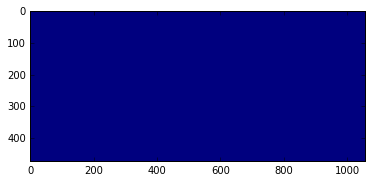

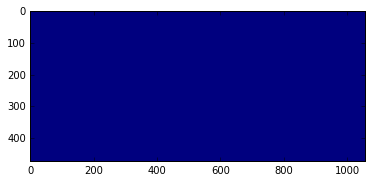

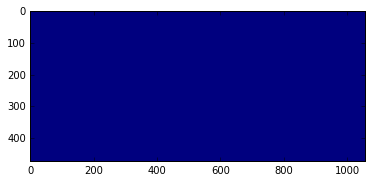

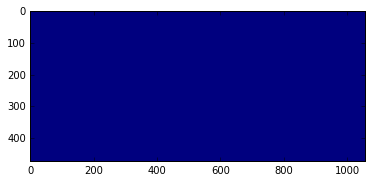

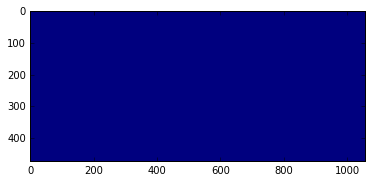

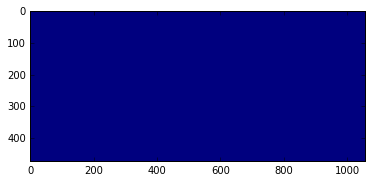

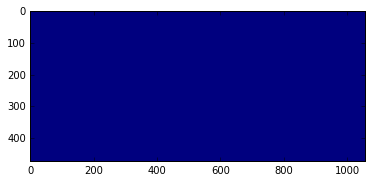

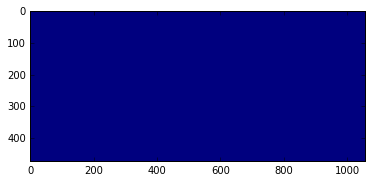

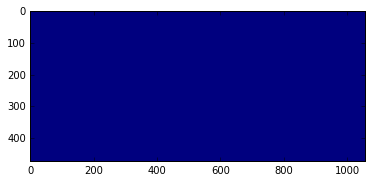

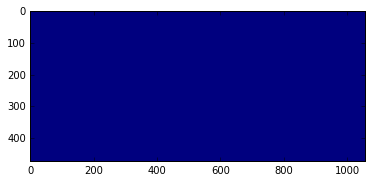

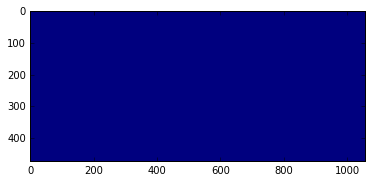

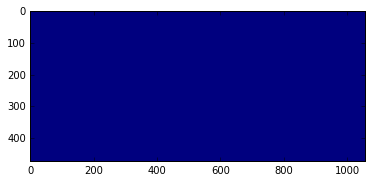

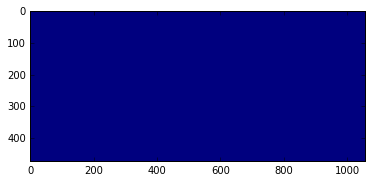

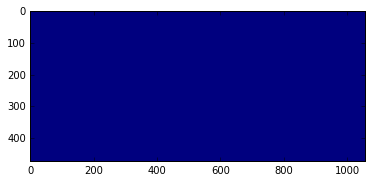

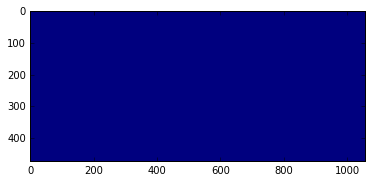

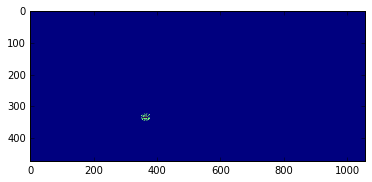

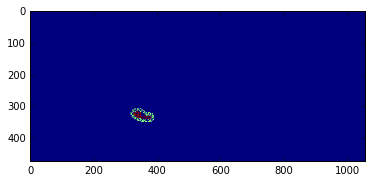

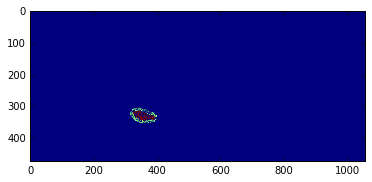

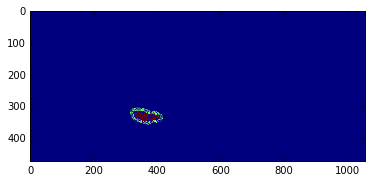

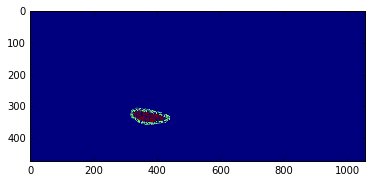

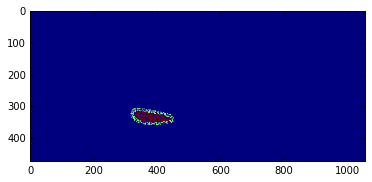

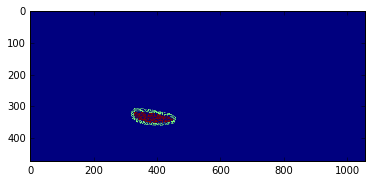

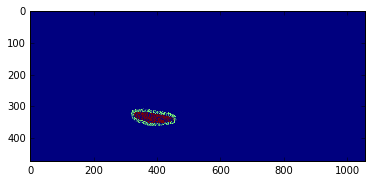

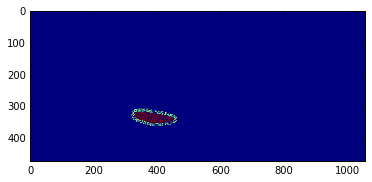

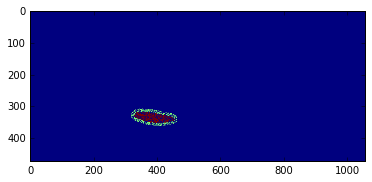

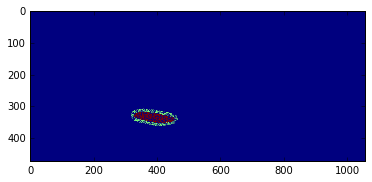

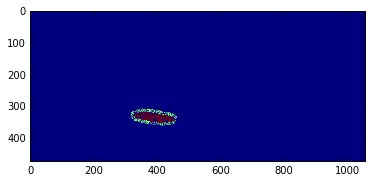

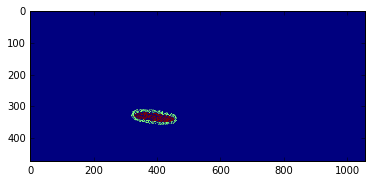

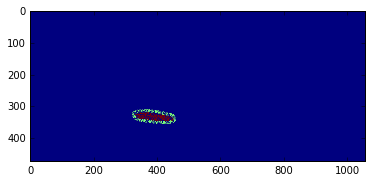

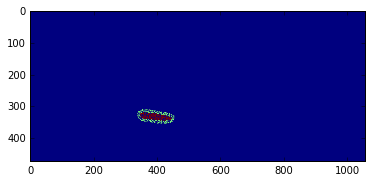

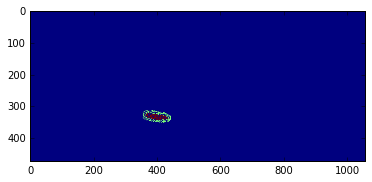

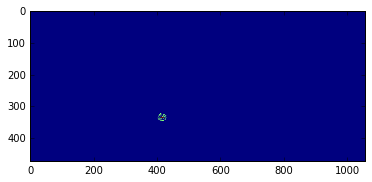

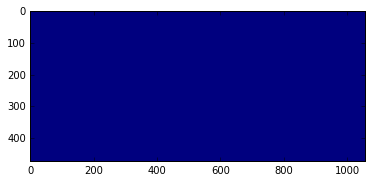

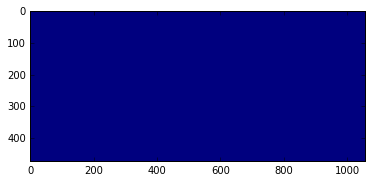

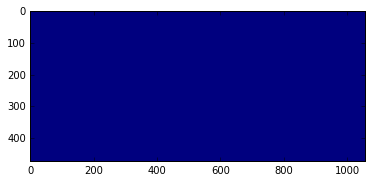

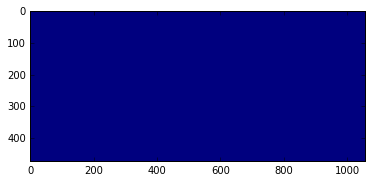

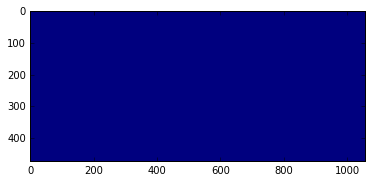

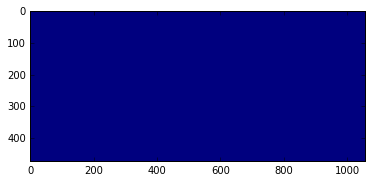

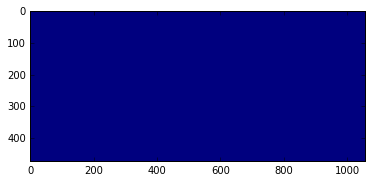

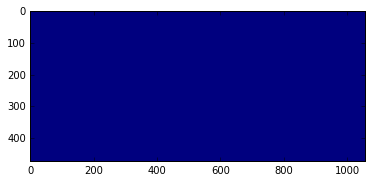

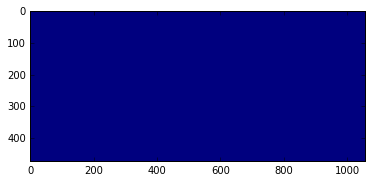

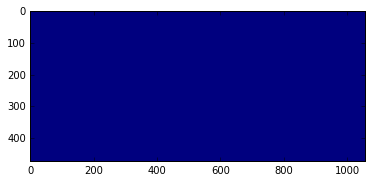

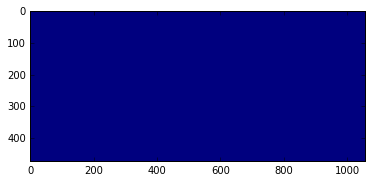

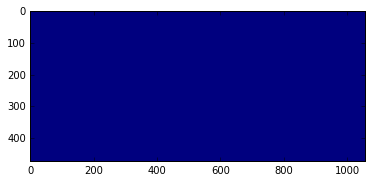

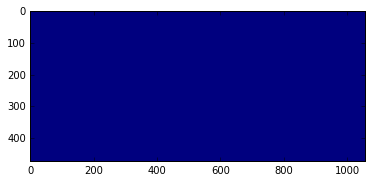

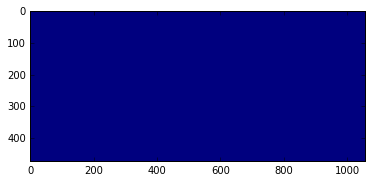

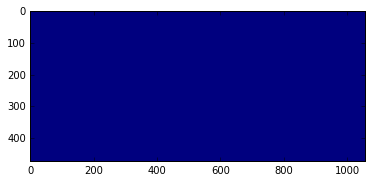

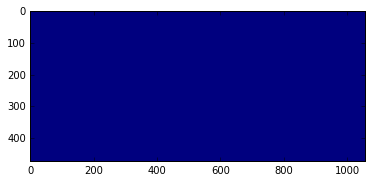

KeyboardInterrupt: 

In [42]:
test_volume = np.zeros_like(atlasProjected_volume, np.uint8)

nzs = surr_nzs['Tz_L']
test_volume[nzs[:,1], nzs[:,0], nzs[:,2]] = 1

nzs2 = atlasProjected_nzs['Tz_L']
test_volume[nzs2[:,1], nzs2[:,0], nzs2[:,2]] = 2

for z in range(0, 300, 5):
    plt.imshow(test_volume[..., z]);
    plt.show();

In [ ]:
# Load test volume

In [43]:
params_dir = create_if_not_exists(atlasAlignParams_dir + '/' + stack)

# with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
    
# T_final = np.array(map(float, lines[1].strip().split()))

In [20]:
t = time.time()

volume2_allLabels = {}

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                      {'stack': stack, 'label': name})).astype(np.float16)
    volume2_allLabels[name] = volume2_roi
    del volume2_roi

test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape

print test_xdim, test_ydim, test_zdim

# test_xdim = volume_xmax - volume_xmin + 1
# test_ydim = volume_ymax - volume_ymin + 1
# test_zdim = volume_zmax - volume_zmin + 1

sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

1056 472 437


load score volumes: 33.481371 seconds


In [21]:
########### Load Gradient ###########

dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

t1 = time.time()

for name in available_labels_unsided:
    
    if name == 'BackG':
        continue

    t = time.time()
    
    dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})
    
    sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~7s

sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # 140s

load gradient RtTg: 10.115889 seconds
load gradient VLL: 8.891345 seconds
load gradient Tz: 6.721006 seconds
load gradient LC: 9.947276 seconds
load gradient 7N: 9.562192 seconds
load gradient Amb: 15.814529 seconds
load gradient 6N: 19.597591 seconds
load gradient AP: 23.003847 seconds
load gradient 5N: 29.917840 seconds
load gradient 12N: 24.671074 seconds
load gradient 7n: 26.989096 seconds
load gradient R: 26.451645 seconds
load gradient Pn: 30.515117 seconds
load gradient LRt: 24.865192 seconds
overall: 267.070604 seconds


In [44]:
def compute_score_and_gradient(T, name):
    
    name_unsided = labelMap_sidedToUnsided[name]
    
    score = 0
    dMdA = np.zeros((12,))
    
    pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
                                 c_prime=test_centroid2).astype(np.int16)

    xs_prime, ys_prime, zs_prime = pts_prime.T

    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

    if np.count_nonzero(valid) > 0:

        xs_prime_valid = xs_prime[valid]
        ys_prime_valid = ys_prime[valid]
        zs_prime_valid = zs_prime[valid]

        voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
        score = voxel_probs_valid.sum()

        Sx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        dxs, dys, dzs = atlasProjected_pts_centered[name][valid].T

        dMdA = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                      Sy*dxs, Sy*dys, Sy*dzs, Sy,
                      Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)

        del voxel_probs_valid, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid

#         sys.stderr.write('########### %s: %f seconds\n' % (labels[l], time.time() - t1))

    del valid, xs_prime, ys_prime, zs_prime, pts_prime
        
    return score, dMdA

In [45]:
def compute_score_and_gradient_surr(T, name):
    
    name_unsided = labelMap_sidedToUnsided[name]
    
    score = 0
    dMdA = np.zeros((12,))
    
    pts_prime = transform_points(T, pts_centered=surr_pts_centered[name], 
                                 c_prime=test_centroid2).astype(np.int16)

    xs_prime, ys_prime, zs_prime = pts_prime.T

    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

    if np.count_nonzero(valid) > 0:

        xs_prime_valid = xs_prime[valid]
        ys_prime_valid = ys_prime[valid]
        zs_prime_valid = zs_prime[valid]

        voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
        score = voxel_probs_valid.sum()

        Sx = dSdxyz[name_unsided][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sy = dSdxyz[name_unsided][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sz = dSdxyz[name_unsided][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        dxs, dys, dzs = surr_pts_centered[name][valid].T

        dMdA = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                      Sy*dxs, Sy*dys, Sy*dzs, Sy,
                      Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)

        del voxel_probs_valid, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid

    del valid, xs_prime, ys_prime, zs_prime, pts_prime
        
    return score, dMdA

In [ ]:
# def compute_score(T, name):
        
#     name_unsided = labelMap_sidedToUnsided[name]
    
#     pts_prime = transform_points(T, pts_centered=atlasProjected_pts_centered[name], 
#                                  c_prime=test_centroid2).astype(np.int16)
                
#     xs_prime, ys_prime, zs_prime = pts_prime.T
    
#     valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
#             (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
#     assert np.count_nonzero(valid) > 0, 'No valid pixel after transform: %s' % name
    
#     xs_prime_valid, ys_prime_valid, zs_prime_valid = pts_prime[valid].T
    
#     voxel_probs_valid = volume2_allLabels[name_unsided][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
#     score = voxel_probs_valid.sum()
    
#     return score

In [ ]:
### all landmarks

12N


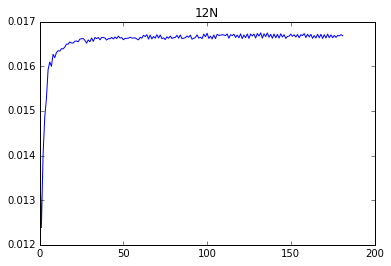

5N_L


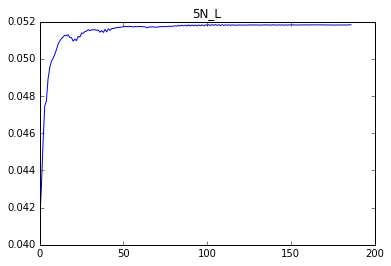

5N_R


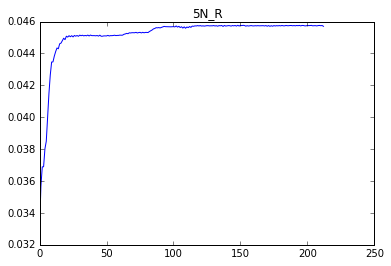

6N_L


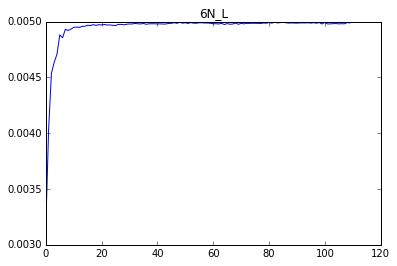

6N_R


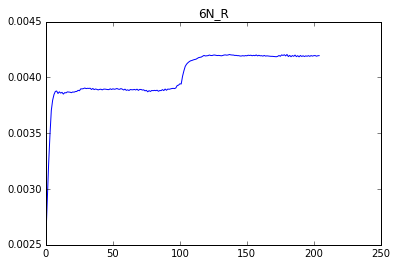

7N_L


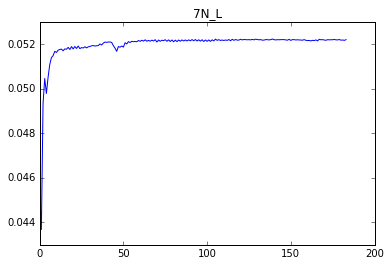

In [ ]:
history_len = 200
T0 = np.array([1,0,0,0,0,1,0,0,0,0,1,0])
max_iter = 5000

for name_of_interest in available_labels_sided:
# for name_of_interest in ['Amb_R']:

    if name_of_interest == 'BackG' or name_of_interest == 'outerContour':
        continue
    
    print name_of_interest
    
    # set the rotation center of both atlas and test volume to the landmark centroid after affine projection
    
    global atlasProjected_centroid, test_centroid2, atlasProjected_pts_centered, surr_pts_centered
    
    atlasProjected_centroid = atlasProjected_nzs[name_of_interest].mean(axis=0)
    test_centroid2 = atlasProjected_centroid.copy()
    atlasProjected_pts_centered = {name: nzs - atlasProjected_centroid for name, nzs in atlasProjected_nzs.iteritems()}
    
    surr_pts_centered = {name: nzs - atlasProjected_centroid for name, nzs in surr_nzs.iteritems()}
    
    ################# Gradient Descent ######################

    lr1, lr2 = (1., 1e-1)

    max_iter_num = 1000
    fudge_factor = 1e-6 #for numerical stability
    dMdA_historical = np.zeros((12,))

    T_best = np.r_[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]

    lr = np.r_[lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1]

    score_best = 0

    scores = []

    for iteration in range(max_iter_num):

#         print 'iteration %d' % iteration

    #     t = time.time()
        s, dMdA = compute_score_and_gradient(T_best, name_of_interest)
    #     sys.stderr.write('compute_score_and_gradient: %f seconds\n' % (time.time() - t)) #~ 2s/iteration or ~.5s: 1e5 samples per landmark
        s_neg, dMdA_neg = compute_score_and_gradient_surr(T_best, name_of_interest)
        
        surr_w = 1.
        dMdA = dMdA - surr_w * dMdA_neg
        s = s - surr_w * s_neg
    
        dMdA_historical += dMdA**2

        dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

        T_best += lr*dMdA_adjusted

    #         logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))
    #         logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

#         print 'score: %f' % s
        scores.append(s)

        history_len = 50
        if iteration > 100:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-5:
                break

        if s > score_best:
    #             logger.info('Current best')
            best_gradient_descent_params = T_best
            score_best = s

    plt.title('%s' % name_of_interest);
    plt.plot(scores);
    plt.show();
    
#     del volume2_allLabels, dSdxyz
    
    create_if_not_exists(atlasAlignOptLogs_dir + '/%(stack)s' % {'stack':stack})
    np.save(atlasAlignOptLogs_dir + '/%(stack)s/%(stack)s_%(name)s_scoreEvolutions_transformUponAffineProjection.npy' % \
            {'stack':stack, 'name': name_of_interest}, scores)
    
    with open(params_dir + '/%(stack)s_%(name)s_transformUponAffineProjection.txt' % {'stack': stack, 'name': name_of_interest}, 
              'w') as f:
        f.write((' '.join(['%f']*12)+'\n') % tuple(best_gradient_descent_params))
        f.write((' '.join(['%d']*3)+'\n') % tuple(np.r_[test_xdim, test_ydim, test_zdim]))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlasProjected_centroid))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid2))

In [49]:
atlasProjected_nzs_full = Parallel(n_jobs=4)(delayed(parallel_where)(name) for name in available_labels_sided)
atlasProjected_nzs_full = dict(zip(available_labels_sided, atlasProjected_nzs_full))

In [84]:
parameters_allLandmarks = {}
atlas_centroid_allLandmarks = {}
test_centroid_allLandmarks = {}

for name in available_labels_sided:
    
    if name == 'BackG' or name == 'outerContour':
        continue
    
    with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_%(name)s_transformUponAffineProjection.txt' % \
                        {'stack': stack, 'name': name}, 'r') as f:
        lines = f.readlines()
        params = np.array(map(float, lines[0].strip().split()))
        test_xdim, test_ydim, test_zdim = np.array(map(int, lines[1].strip().split()))
        atlas_c = np.array(map(float, lines[2].strip().split()))
        test_c = np.array(map(float, lines[3].strip().split()))
    
    parameters_allLandmarks[name] = params
    atlas_centroid_allLandmarks[name] = atlas_c
    test_centroid_allLandmarks[name] = test_c

In [85]:
################# PROJECT ATLAS TO IMAGE ######################

atlas_nzs_projected_to_test = {name: transform_points(parameters_allLandmarks[name], pts=nzs, 
                                                      c=atlas_centroid_allLandmarks[name], 
                                                      c_prime=test_centroid_allLandmarks[name]).astype(np.int16)
                               for name, nzs in atlasProjected_nzs_full.iteritems() 
                               if not (name == 'BackG' or name == 'outerContour')}

test_volume_atlas_projected = np.zeros((test_ydim, test_xdim, test_zdim), np.int16)

for name in available_labels_sided:

    if name == 'BackG' or name == 'outerContour':
        continue
    
    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[name].T

    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
            (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

    atlas_xs, atlas_ys, atlas_zs = atlasProjected_nzs_full[name].T
    
    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    atlasProjected_volume[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]

del atlas_nzs_projected_to_test

In [86]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[0] = 1.

In [87]:
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

60 347


In [91]:
annotationsViz_rootdir = '/home/yuncong/csd395/CSHL_localAdjustedVolumeViz_affine_surr_%.1f/' % surr_w
annotationsViz_dir = create_if_not_exists(annotationsViz_rootdir + '/' + stack)

In [93]:
dm = DataManager(stack=stack)

for z in range(0, test_zdim, 5):
# for z in range(380, 400, 1):
    
    dm.set_slice(map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
                                                                     volume_xmin:volume_xmax+1].copy()

    projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

    for label_ind, cnts in projected_cnts.iteritems():
        for cnt in cnts:
            cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

#     plt.figure(figsize=(10, 10));
#     plt.title('z = %d' % z)
#     plt.imshow(viz)
#     plt.show()
    
    cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_localAdjustedVolumeViz_z%(z)04d.jpg' % \
                {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
                img_as_ubyte(viz[..., [2,1,0]]))

In [ ]:
best_gradient_descent_params.reshape((3,4))